In [1]:
import math
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from folium import plugins
from humanfriendly import format_timespan

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('./export_55357022/activities.csv')

In [3]:
# inspect data
df.head()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,Activity Gear,Filename,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,Max Speed,Average Speed,Elevation Gain,Elevation Loss,Elevation Low,Elevation High,Max Grade,Average Grade,Average Positive Grade,Average Negative Grade,Max Cadence,Average Cadence,Max Heart Rate.1,Average Heart Rate,Max Watts,Average Watts,Calories,Max Temperature,Average Temperature,Relative Effort.1,Total Work,Number of Runs,Uphill Time,Downhill Time,Other Time,Perceived Exertion,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.type"">Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.start_time"">Start Time</span>",Weighted Average Power,Power Count,Prefer Perceived Exertion,Perceived Relative Effort,Commute.1,Total Weight Lifted,From Upload,Grade Adjusted Distance,Weather Observation Time,Weather Condition,Weather Temperature,Apparent Temperature,Dewpoint,Humidity,Weather Pressure,Wind Speed,Wind Gust,Wind Bearing,Precipitation Intensity,Sunrise Time,Sunset Time,Moon Phase,Bike,Gear,Precipitation Probability,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>"
0,3327605482,"Apr 20, 2020, 6:25:27 PM",Afternoon Walk,Walk,Lunch walk,1269,1.74,NaN,NaN,False,NaN,activities/3327605482.gpx,68.038902,NaN,1269.0,1214.0,1739.900024,3.2,1.433196,17.424501,17.724501,256.200012,265.500000,7.4,-0.017242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,0.0,21.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3332635643,"Apr 21, 2020, 6:31:21 PM",Afternoon Walk,Walk,NaN,1399,1.64,NaN,NaN,False,NaN,activities/3332635643.gpx,68.038902,NaN,1399.0,1178.0,1642.099976,4.2,1.393973,17.174109,13.574100,256.200012,265.200012,6.8,0.219231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,0.0,13.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3333716595,"Apr 21, 2020, 11:31:27 PM",Evening Run,Run,NaN,1735,5.87,NaN,NaN,False,NaN,activities/3333716595.gpx,68.038902,NaN,1735.0,1725.0,5875.3

In [4]:
# preprocessing - removing html tags from columns
df.columns = df.columns.str.replace(r'<[^<>]*>', '', regex=True)

In [5]:
cols = df.columns.values.tolist()
for k, v in enumerate(cols):
    print(k, v)

0 Activity ID
1 Activity Date
2 Activity Name
3 Activity Type
4 Activity Description
5 Elapsed Time
6 Distance
7 Max Heart Rate
8 Relative Effort
9 Commute
10 Activity Gear
11 Filename
12 Athlete Weight
13 Bike Weight
14 Elapsed Time.1
15 Moving Time
16 Distance.1
17 Max Speed
18 Average Speed
19 Elevation Gain
20 Elevation Loss
21 Elevation Low
22 Elevation High
23 Max Grade
24 Average Grade
25 Average Positive Grade
26 Average Negative Grade
27 Max Cadence
28 Average Cadence
29 Max Heart Rate.1
30 Average Heart Rate
31 Max Watts
32 Average Watts
33 Calories
34 Max Temperature
35 Average Temperature
36 Relative Effort.1
37 Total Work
38 Number of Runs
39 Uphill Time
40 Downhill Time
41 Other Time
42 Perceived Exertion
43 Type
44 Start Time
45 Weighted Average Power
46 Power Count
47 Prefer Perceived Exertion
48 Perceived Relative Effort
49 Commute.1
50 Total Weight Lifted
51 From Upload
52 Grade Adjusted Distance
53 Weather Observation Time
54 Weather Condition
55 Weather Temperature


In [6]:
# converting date from string to datetime
df['activity_date'] = pd.to_datetime(df['Activity Date'], infer_datetime_format=True)

In [7]:
# select date range in 2022
mask = (df['activity_date'] >= '2022-01-01') & (df['activity_date'] <= '2022-12-31')
df = df.loc[mask]

In [8]:
# converting from metric to imperial units for American context
# convert Distance column from default (km) to miles
df['Distance'] = df['Distance'].replace(',', '').astype(float)
df['distance_mile'] = df['Distance'] * 0.621371

# convert Elevation Gain from meter to feet
df['Elevation Gain'] = df['Elevation Gain'].replace(',', '').astype(float)
df['elevation_gain_ft'] = df['Elevation Gain'] * 3.28084

In [9]:
def meter_per_second_to_pace(n):
    if (n == 0):
        return 0
    d, n = math.modf(60/(n*2.236936))
    return str(int(n)) + ':' + str(int(d*60))

In [10]:
# avegrage speed is meter/second, convert it to pace
# https://www.dummies.com/article/home-auto-hobbies/\
# sports-recreation/converting-miles-per-hour-to-minutes-per-mile-194716/
df['Average Speed'] = df['Average Speed'].astype(float)
df['average_speed_mph'] = df['Average Speed']*2.236936
df['pace'] = df['Average Speed'].apply(lambda x: meter_per_second_to_pace(x))

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Run'),
  Text(1, 0, 'Hike'),
  Text(2, 0, 'Walk'),
  Text(3, 0, 'Kayaking'),
  Text(4, 0, 'Ride'),
  Text(5, 0, 'Weight Training'),
  Text(6, 0, 'Workout')])

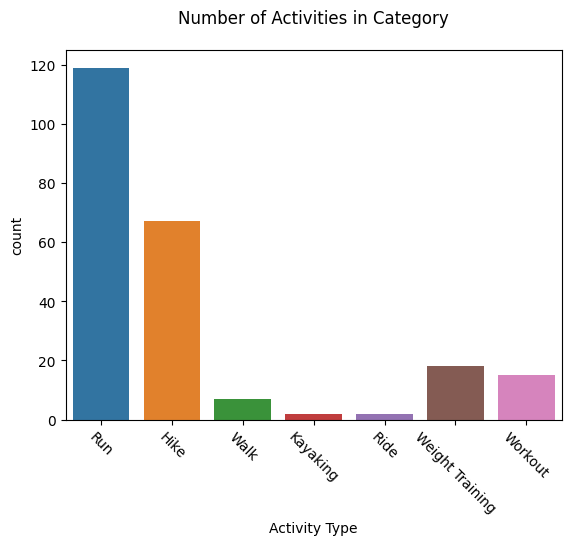

In [11]:
# activity categories
g = sns.countplot(x='Activity Type', data=df)

g.set_title('Number of Activities in Category', y=1.05)

plt.xticks(rotation=-45)

In [12]:
df.groupby(['Activity Type']).size()

Activity Type
Hike                67
Kayaking             2
Ride                 2
Run                119
Walk                 7
Weight Training     18
Workout             15
dtype: int64

In [13]:
# number of activities
len(df)

230

In [14]:
# number of active days
len(df.groupby([df['activity_date'].dt.date]))

160

In [15]:
# adding new column month 
df['activity_month'] = df['activity_date'].dt.month
df['activity_day'] = df['activity_date'].dt.day

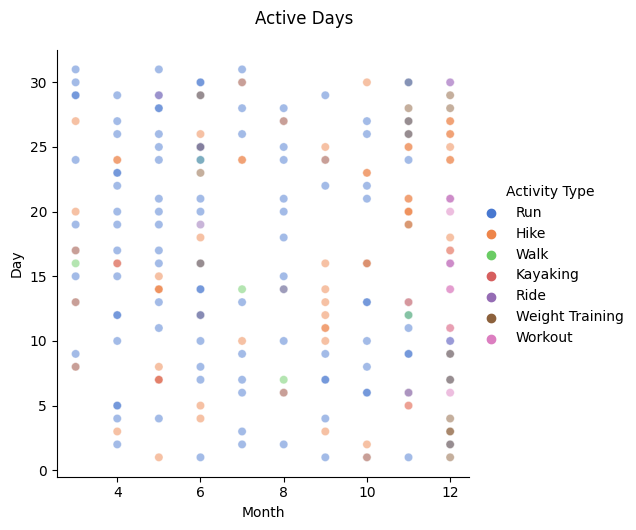

In [16]:
g = sns.relplot(x='activity_month', y='activity_day', kind='scatter',
            hue='Activity Type', alpha=.5, palette="muted", data=df)

g.fig.suptitle('Active Days', y=1.05)

g.set(xlabel='Month', ylabel='Day')

In [17]:
# longest distance activity based on activity type
df.groupby(['Activity Type'], sort=False)['distance_mile'].max()

Activity Type
Run                14.098908
Hike               16.491186
Walk                8.599775
Kayaking            4.709992
Ride               11.787408
Weight Training     4.536008
Workout             2.174799
Name: distance_mile, dtype: float64

In [18]:
# list those longest activities?
# get temp subset of activities because yoga and weight training doesn't have distance
df_distance = df[df['distance_mile'] > 0]
idx = df_distance.groupby(['Activity Type'])['distance_mile'].transform(max) == df_distance['distance_mile']
df_distance[idx]

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,Activity Gear,Filename,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,Max Speed,Average Speed,Elevation Gain,Elevation Loss,Elevation Low,Elevation High,Max Grade,Average Grade,Average Positive Grade,Average Negative Grade,Max Cadence,Average Cadence,Max Heart Rate.1,Average Heart Rate,Max Watts,Average Watts,Calories,Max Temperature,Average Temperature,Relative Effort.1,Total Work,Number of Runs,Uphill Time,Downhill Time,Other Time,Perceived Exertion,Type,Start Time,Weighted Average Power,Power Count,Prefer Perceived Exertion,Perceived Relative Effort,Commute.1,Total Weight Lifted,From Upload,Grade Adjusted Distance,Weather Observation Time,Weather Condition,Weather Temperature,Apparent Temperature,Dewpoint,Humidity,Weather Pressure,Wind Speed,Wind Gust,Wind Bearing,Precipitation Intensity,Sunrise Time,Sunset Time,Moon Phase,Bike,Gear,Precipitation Probability,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,Jump Count,Total Grit,Avg Flow,Flagged,Avg Elapsed Speed,Dirt Distance,Newly Explored Distance,Newly Explored Dirt Distance,Sport Type,activity_date,distance_mile,elevation_gain_ft,average_speed_mph,pace,activity_month,activity_day
65,6994172612,"Apr 16, 2022, 10:02:50 PM",Afternoon Activity,Kayaking,NaN,9599,7.58,NaN,NaN,False,NaN,activities/6994172612.gpx,NaN,NaN,9599.0,6571.0,7584.620117,5.227857,1.154257,10.324402,0.924402,129.199997,140.500000,25.411283,0.123935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.790147,1705.699951,NaN,NaN,NaN,2022-04-16 22:02:50,4.709992,33.872711,2.581998,23:14,4,16
66,6998405974,"Apr 17, 2022, 3:29:26 PM","@Government Canyon, external & internal work w...",Run,NaN,13651,22.69,NaN,NaN,False,NaN,activities/6998405974.gpx,NaN,NaN,13651.0,9680.0,22693.330078,5.862109,2.344352,307.636078,307.235992,307.500000,417.399994,38.148567,0.001763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1925.863159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,23348.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.662393,22628.500000,NaN,NaN,NaN,2022-04-17 15:29:26,14.098908,1009.304750,5.244166,11:26,4,17
100,7224455136,"May 29, 2022, 8:43:14 PM",Bike!,Ride,NaN,10986,18.97,NaN,NaN,False,NaN,activities/7224455136.gpx,NaN,NaN,10986.0,6630.0,18973.160156,12.770020,2.861713,161.658768,159.858765,261.799988,281.799988,44.210526,0.009487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.006516,539.697021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.727031,6842.100098,NaN,NaN,NaN,2022-05-29 20:43:14,11.787408,530.376551,6.401470,9:22,5,29
149,7595239073,"Aug 7, 2022, 2:06:22 AM",Night Walk,Walk,Forgot to end strava at mile 3,4298,13.84,NaN,NaN,False,NaN,activities/7595239073.gpx,NaN,NaN,4298.0,3935.0,13846.690430,34.748047,3.518854,118.174522,53.375000,133.399994,209.300003,7.946104,0.467982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1142.122559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.221659,2595.000000,NaN,NaN,NaN,2022-08-07 02:06:22,8.599775,387.711700,7.871451,7:37,8,7
174,7819047539,"Sep 16, 2022, 1:21:41 PM",S. Rim to River to S. Rim,Hike,NaN,25449,26.54,NaN,NaN,False,NaN,activities/7819047539.gpx,NaN,NaN,25449.0,20948.0,26547.210938,5.436914,1.267291,1449.818726,1555.119995,754.599976,2192.899902,49.823910,-0.396652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2189.702637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN

In [19]:
# longest elapsed time activity based on activity type
df.groupby(['Activity Type'], sort=False)['Elapsed Time'].max()

Activity Type
Run                16899
Hike               30670
Walk                7006
Kayaking            9599
Ride               10986
Weight Training     6187
Workout             5822
Name: Elapsed Time, dtype: int64

In [20]:
# what are the longest activities based on time and category
# convert moving time to hours and minutes,  raw data is in seconds
df['friendly_time'] = df['Moving Time'].apply(lambda x: format_timespan(x))
idx = df.groupby(['Activity Type'])['Moving Time'].transform(max) == df['Moving Time']
df[idx][['Activity Date', 'Activity Name', 'Activity Type', 'distance_mile', 'friendly_time']] \
        .sort_values(['friendly_time'], ascending=False)

,Activity Date,Activity Name,Activity Type,distance_mile,friendly_time
174,"Sep 16, 2022, 1:21:41 PM",S. Rim to River to S. Rim,Hike,16.491186,"5 hours, 49 minutes and 8 seconds"
66,"Apr 17, 2022, 3:29:26 PM","@Government Canyon, external & internal work w...",Run,14.098908,"2 hours, 41 minutes and 20 seconds"
100,"May 29, 2022, 8:43:14 PM",Bike!,Ride,11.787408,"1 hour, 50 minutes and 30 seconds"
65,"Apr 16, 2022, 10:02:50 PM",Afternoon Activity,Kayaking,4.709992,"1 hour, 49 minutes and 31 seconds"
245,"Dec 14, 2022, 12:32:20 AM",Evening Workout,Workout,0.000000,"1 hour, 34 minutes and 38 seconds"
264,"Dec 28, 2022, 10:37:00 PM",Arms. Both the left and right,Weight Training,0.000000,"1 hour, 30 minutes and 16 seconds"
202,"Nov 6, 2022, 2:40:50 AM",Night Walk,Walk,4.144545,"1 hour, 25 minutes and 49 seconds"


In [21]:
# Elevation
# What about just elevations not based on activities types
elevation = df[['Activity Date', 'Activity Name', 'Activity Type', 'distance_mile', 'friendly_time', 'elevation_gain_ft']] \
        .sort_values(by=['elevation_gain_ft'], ascending=False).head(10)

/usr/local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 129305 (\N{CALL ME HAND}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 129305 (\N{CALL ME HAND}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 129305 (\N{CALL ME HAND}) missing from current font.
  fig.canvas.draw()


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'S. Rim to River to S. Rim '),
  Text(1, 0, 'Guadalupe Peak '),
  Text(2, 0, 'Angel\'s Landing at Zion "My Chain!"'),
  Text(3, 0, 'Emory Peak at Big Bend '),
  Text(4, 0, 'Hike at Bryce Canyon '),
  Text(5, 0, 'Fairyland Loop '),
  Text(6, 0, 'Lincoln National Forest via Alamo Canyon 104 Roundup Ground 107'),
  Text(7, 0, 'Lost Mine trail, searching for the sunrise'),
  Text(8, 0, '@Government Canyon, external & internal work was dropped and reshaped here today 🤙'),
  Text(9, 0, '6 miler Sundays @ Friedrich with SA Hikers')])

/usr/local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 129305 (\N{CALL ME HAND}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129305 (\N{CALL ME HAND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


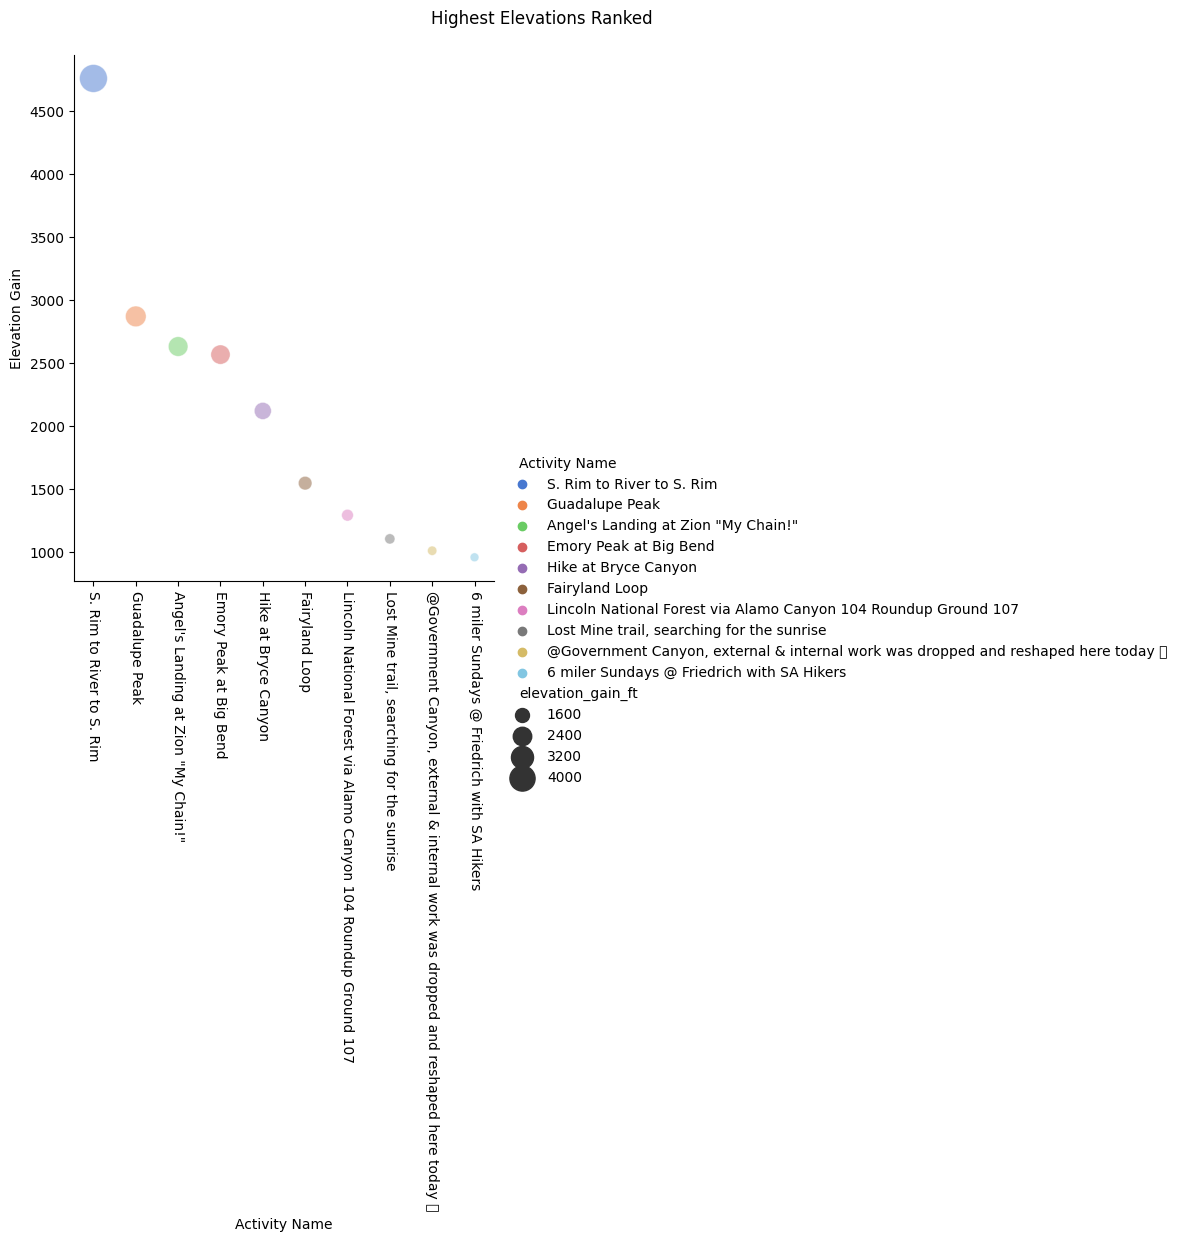

In [22]:
g = sns.relplot(x='Activity Name', y='elevation_gain_ft', kind='scatter', hue='Activity Name', size='elevation_gain_ft',
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=elevation)

g.fig.suptitle('Highest Elevations Ranked', y=1.05)

g.set(xlabel='Activity Name', ylabel='Elevation Gain')

plt.xticks(rotation=-90)

In [23]:
# fastest activity (Run) based on primary activity type
df_run = df[df['Activity Type'] == 'Run']
df_run.sort_values(by=['average_speed_mph'], ascending=False).head()
# what is the measurement unit for speed?

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,Activity Gear,Filename,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,Max Speed,Average Speed,Elevation Gain,Elevation Loss,Elevation Low,Elevation High,Max Grade,Average Grade,Average Positive Grade,Average Negative Grade,Max Cadence,Average Cadence,Max Heart Rate.1,Average Heart Rate,Max Watts,Average Watts,Calories,Max Temperature,Average Temperature,Relative Effort.1,Total Work,Number of Runs,Uphill Time,Downhill Time,Other Time,Perceived Exertion,Type,Start Time,Weighted Average Power,Power Count,Prefer Perceived Exertion,Perceived Relative Effort,Commute.1,Total Weight Lifted,From Upload,Grade Adjusted Distance,Weather Observation Time,Weather Condition,Weather Temperature,Apparent Temperature,Dewpoint,Humidity,Weather Pressure,Wind Speed,Wind Gust,Wind Bearing,Precipitation Intensity,Sunrise Time,Sunset Time,Moon Phase,Bike,Gear,Precipitation Probability,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,Jump Count,Total Grit,Avg Flow,Flagged,Avg Elapsed Speed,Dirt Distance,Newly Explored Distance,Newly Explored Dirt Distance,Sport Type,activity_date,distance_mile,elevation_gain_ft,average_speed_mph,pace,activity_month,activity_day,friendly_time
176,7859255734,"Sep 24, 2022, 1:00:56 PM",Head for the cure 5k,Run,NaN,1660,4.82,NaN,NaN,False,NaN,activities/7859255734.gpx,NaN,NaN,1660.0,1214.0,4826.890137,7.786000,3.976022,6.441538,6.341540,197.399994,200.800003,2.609012,0.002072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,398.493683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,4831.200195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.907765,0.0,NaN,NaN,NaN,2022-09-24 13:00:56,2.995008,21.133657,8.894106,6:44,9,24,20 minutes and 14 seconds
93,7178997028,"May 21, 2022, 1:13:15 PM",Beach2Bay leg 3 accomplished,Run,NaN,2051,7.04,NaN,NaN,False,NaN,activities/7178997028.gpx,NaN,NaN,2051.0,1939.0,7041.169922,8.462001,3.631341,38.012966,34.512966,0.300000,24.500000,6.593410,0.049708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,585.095825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,7093.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.433042,0.0,NaN,NaN,NaN,2022-05-21 13:13:15,4.374452,124.714460,8.123077,7:23,5,21,32 minutes and 19 seconds
51,6901185524,"Mar 29, 2022, 11:28:24 AM",Texas Mountain Laurel is in the air. RUN! 🤙,Run,NaN,1866,5.80,NaN,NaN,False,NaN,activities/6901185524.gpx,NaN,NaN,1866.0,1680.0,5800.740234,6.608008,3.452821,35.491070,35.291073,231.300003,250.800003,10.678883,0.003448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,482.552490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,5850.299805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.108650,0.0,NaN,NaN,NaN,2022-03-29 11:28:24,3.603952,116.440521,7.723741,7:46,3,29,28 minutes
92,7173579729,"May 20, 2022, 11:41:36 AM","Work hard; Beach hard, upcoming Beach2Bay 22'",Run,NaN,1757,5.86,NaN,NaN,False,NaN,activities/7173579729.gpx,NaN,NaN,1757.0,1708.0,5863.870117,5.630005,3.433179,33.368134,32.868134,230.800003,250.800003,11.376513,0.008527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,488.161377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,5918.299805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.337433,0.0,NaN,NaN,NaN,2022-05-20 11:41:36,3.641234,109.475507,7.679802,7:48,5,20,28 minutes and 28 seconds
165,7766898493,"Sep 7, 2022, 12:00:41 AM",5k appetizer 🌎,Run,NaN,1869,5.57,NaN,NaN,False,NaN,activities/7766898493.gpx,NaN,NaN,1869.0,1654.0,5575.479980,7.710059,3.370907,33.993343,34.293343,231.600006,250.800003,8.879483,-0.005381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,463.738037,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [24]:
# longest run
df_run.sort_values(by=['distance_mile'], ascending=False).head()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,Activity Gear,Filename,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,Max Speed,Average Speed,Elevation Gain,Elevation Loss,Elevation Low,Elevation High,Max Grade,Average Grade,Average Positive Grade,Average Negative Grade,Max Cadence,Average Cadence,Max Heart Rate.1,Average Heart Rate,Max Watts,Average Watts,Calories,Max Temperature,Average Temperature,Relative Effort.1,Total Work,Number of Runs,Uphill Time,Downhill Time,Other Time,Perceived Exertion,Type,Start Time,Weighted Average Power,Power Count,Prefer Perceived Exertion,Perceived Relative Effort,Commute.1,Total Weight Lifted,From Upload,Grade Adjusted Distance,Weather Observation Time,Weather Condition,Weather Temperature,Apparent Temperature,Dewpoint,Humidity,Weather Pressure,Wind Speed,Wind Gust,Wind Bearing,Precipitation Intensity,Sunrise Time,Sunset Time,Moon Phase,Bike,Gear,Precipitation Probability,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,Jump Count,Total Grit,Avg Flow,Flagged,Avg Elapsed Speed,Dirt Distance,Newly Explored Distance,Newly Explored Dirt Distance,Sport Type,activity_date,distance_mile,elevation_gain_ft,average_speed_mph,pace,activity_month,activity_day,friendly_time
66,6998405974,"Apr 17, 2022, 3:29:26 PM","@Government Canyon, external & internal work w...",Run,NaN,13651,22.69,NaN,NaN,False,NaN,activities/6998405974.gpx,NaN,NaN,13651.0,9680.0,22693.330078,5.862109,2.344352,307.636078,307.235992,307.500000,417.399994,38.148567,0.001763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1925.863159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,23348.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.662393,22628.500000,NaN,NaN,NaN,2022-04-17 15:29:26,14.098908,1009.304750,5.244166,11:26,4,17,"2 hours, 41 minutes and 20 seconds"
208,8107748681,"Nov 12, 2022, 2:00:50 PM",Birthday half marathon 🎉👏🌱,Run,NaN,10077,21.91,NaN,NaN,False,NaN,activities/8680583816.fit.gz,NaN,NaN,10077.0,9619.0,21909.250000,3.559998,2.277706,268.306061,612.000000,202.199997,247.100006,13.000000,0.013693,NaN,NaN,94.0,83.008736,NaN,NaN,NaN,NaN,1557.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,22416.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.174184,4892.399902,NaN,NaN,NaN,2022-11-12 14:00:50,13.614239,880.269256,5.095082,11:46,11,12,"2 hours, 40 minutes and 19 seconds"
155,7671136171,"Aug 20, 2022, 3:09:03 PM","Savannah & Lytle, we meet again",Run,NaN,8983,19.21,NaN,NaN,False,NaN,activities/7671136171.gpx,NaN,NaN,8983.0,7219.0,19210.119141,4.807983,2.661050,97.416748,97.316750,295.700012,314.700012,15.147114,0.000521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1593.809814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,19322.800781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.138497,19210.099609,NaN,NaN,NaN,2022-08-20 15:09:03,11.936537,319.608764,5.952598,10:4,8,20,2 hours and 19 seconds
164,7753325488,"Sep 4, 2022, 11:32:54 AM",Sunday double vision,Run,NaN,7548,16.72,NaN,NaN,False,NaN,activities/7753325488.gpx,NaN,NaN,7548.0,7180.0,16719.929688,4.630078,2.328681,63.597057,62.197056,255.800003,291.500000,12.800000,0.008373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1386.116699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,16804.800781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.215147,2826.300049,NaN,NaN,NaN,2022-09-04 11:32:54,10.389323,208.651770,5.209110,11:31,9,4,"1 hour, 59 minutes and 40 seconds"
156,7675514077,"Aug 21, 2022, 11:18:53 AM",Sunday fun run,Run,NaN,8456,16.67,NaN,NaN,False,NaN,activities/7675514077.gpx,NaN,NaN,8456.0,7430.0,16669.849609,4.450000,2.243587,58.98700

[Text(0.5, 0, 'Distance (mile)'), Text(0, 0.5, 'Count')]

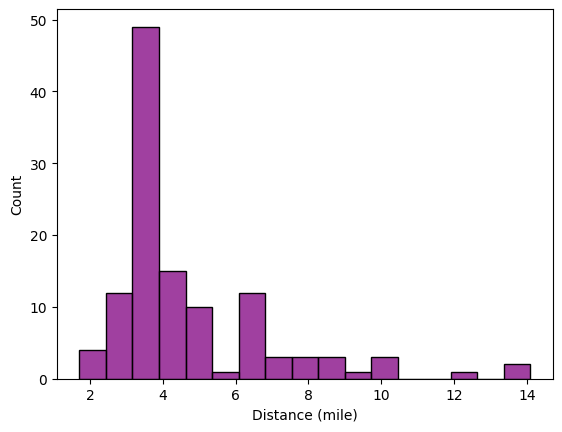

In [25]:
# Distribution of Runs
g = sns.histplot(x='distance_mile', data=df_run, color='purple')
g.set(xlabel='Distance (mile)', ylabel='Count')

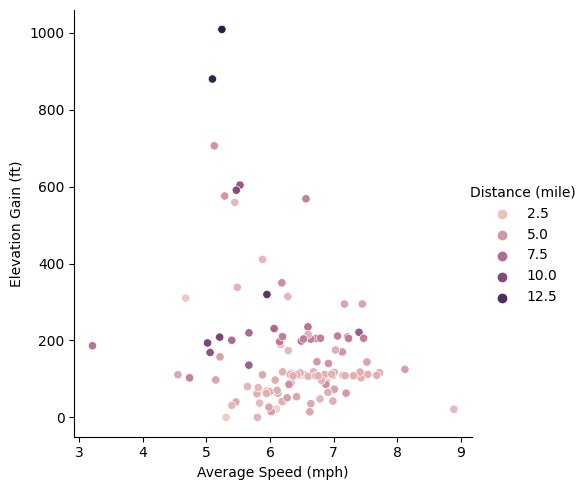

In [26]:
# run speed relate to distance and elevation gain
g = sns.relplot(x='average_speed_mph', y='elevation_gain_ft', hue='distance_mile', data=df_run, kind='scatter')
g.set(xlabel='Average Speed (mph)', ylabel='Elevation Gain (ft)')
g._legend.set_title('Distance (mile)')

In [27]:
# unique activity names
df[~df['Activity Name'].str.contains('Fitbod|Lunch|Afternoon|Evening|Night|Morning|Orange|Black Swan')] \
    .sort_values(by='Activity Name', key=lambda x: x.str.len(), ascending=False)

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,Activity Gear,Filename,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,Max Speed,Average Speed,Elevation Gain,Elevation Loss,Elevation Low,Elevation High,Max Grade,Average Grade,Average Positive Grade,Average Negative Grade,Max Cadence,Average Cadence,Max Heart Rate.1,Average Heart Rate,Max Watts,Average Watts,Calories,Max Temperature,Average Temperature,Relative Effort.1,Total Work,Number of Runs,Uphill Time,Downhill Time,Other Time,Perceived Exertion,Type,Start Time,Weighted Average Power,Power Count,Prefer Perceived Exertion,Perceived Relative Effort,Commute.1,Total Weight Lifted,From Upload,Grade Adjusted Distance,Weather Observation Time,Weather Condition,Weather Temperature,Apparent Temperature,Dewpoint,Humidity,Weather Pressure,Wind Speed,Wind Gust,Wind Bearing,Precipitation Intensity,Sunrise Time,Sunset Time,Moon Phase,Bike,Gear,Precipitation Probability,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,Jump Count,Total Grit,Avg Flow,Flagged,Avg Elapsed Speed,Dirt Distance,Newly Explored Distance,Newly Explored Dirt Distance,Sport Type,activity_date,distance_mile,elevation_gain_ft,average_speed_mph,pace,activity_month,activity_day,friendly_time
66,6998405974,"Apr 17, 2022, 3:29:26 PM","@Government Canyon, external & internal work w...",Run,NaN,13651,22.69,NaN,NaN,False,NaN,activities/6998405974.gpx,NaN,NaN,13651.0,9680.0,22693.330078,5.862109,2.344352,307.636078,307.235992,307.500000,417.399994,38.148567,0.001763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1925.863159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,23348.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.662393,22628.500000,NaN,NaN,NaN,2022-04-17 15:29:26,14.098908,1009.304750,5.244166,11:26,4,17,"2 hours, 41 minutes and 20 seconds"
69,7023668594,"Apr 22, 2022, 4:14:15 PM","@Pearsall Park, great place for hill work and ...",Run,NaN,2710,5.07,NaN,NaN,False,NaN,activities/7023668594.gpx,NaN,NaN,2710.0,1930.0,5077.359863,5.881995,2.630756,125.214859,125.914864,186.600006,236.300003,40.621288,-0.013787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,466.888916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,5660.399902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.873564,2516.000000,NaN,NaN,NaN,2022-04-22 16:14:15,3.150351,410.809918,5.884834,10:11,4,22,32 minutes and 10 seconds
57,6932768050,"Apr 4, 2022, 11:49:26 PM","When you misread street name for meet up...""Ea...",Run,@Leon Creek Greenway,2918,8.35,NaN,NaN,False,NaN,activities/6932768050.gpx,NaN,NaN,2918.0,2699.0,8350.730469,8.940002,3.094009,42.693863,41.793865,222.500000,244.600006,26.635138,0.010778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,696.770081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,8447.400391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.861799,134.100006,NaN,NaN,NaN,2022-04-04 23:49:26,5.188448,140.071733,6.921100,8:40,4,4,44 minutes and 59 seconds
225,8176618150,"Nov 27, 2022, 2:13:02 PM",Last long run with Anthony before he dies ☠️ 😆...,Run,NaN,5540,13.81,NaN,NaN,False,NaN,activities/8758530297.fit.gz,NaN,NaN,5540.0,5452.0,13815.570312,3.158008,2.534037,41.373333,271.000000,255.800003,288.600006,5.086120,0.004343,NaN,NaN,88.0,83.908722,NaN,NaN,NaN,NaN,932.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,13858.200195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.493785,119.599998,NaN,NaN,NaN,2022-11-27 14:13:02,8.581134,135.739286,5.668479,10:35,11,27,"1 hour, 30 minutes and 52 seconds"
259,8290877966,"Dec 25, 2022, 6:40:30 PM",Lincoln National Forest via Alamo Canyon 104 R...,Hike,NaN,10970,10.04,NaN,N

In [28]:
df_activities = df[df['distance_mile'] > 0]

In [29]:
df_activities[['Activity ID', 'Filename']].to_pickle('activities_javi.pkl')
# refer to parse_gpx_activies.py for parsing and importing location data from .gpx to dataframe

In [30]:
df_locations = pd.read_pickle('locations_javi.pkl')

In [31]:
df_locations.head()

,latitude,longitude,elevation,activity_name
0,29.469841,-98.646045,240.7,6791938473
1,29.640301,-98.626373,356.4,6793771260
2,29.445882,-98.480504,200.4,6795061022
3,29.640259,-98.626418,356.7,6818116284
4,29.640430,-98.626366,356.0,6819086870


In [32]:
# join the two dfs
df_locations['activity_name'] = df_locations['activity_name'].astype(int)
merged_df = pd.merge(df, df_locations, left_on='Activity ID', right_on='activity_name')

In [33]:
# drop duplicated activity ID
merged_df.drop('activity_name', axis=1, inplace=True)

In [34]:
len(merged_df)

13203

In [2]:
# merged_df.to_pickle('merged_activity_location.pkl')
# merged_df = pd.read_pickle('merged_activity_location.pkl')

In [35]:
# converting to geopandas
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.longitude, merged_df.latitude))

In [36]:
len(gdf)

13203

In [37]:
states = gpd.read_file('./cb_2018_us_state/cb_2018_us_state_500k.shp')
# states = states.to_crs("EPSG:3395")
# drop alaska, hawaii etc
values = ['Hawaii', 'Alaska', 'Commonwealth of the Northern Mariana Islands', 'Guam', \
          'United States Virgin Islands', 'American Samoa']

# drop rows that contain any value in the list
states = states[states.NAME.isin(values) == False]

In [38]:
# sample down each activity by its first data point
sample_gdf = gdf.groupby('Activity ID').first()

(-127.74018625000001, -62.24358475, 16.3082261, 50.9594119)

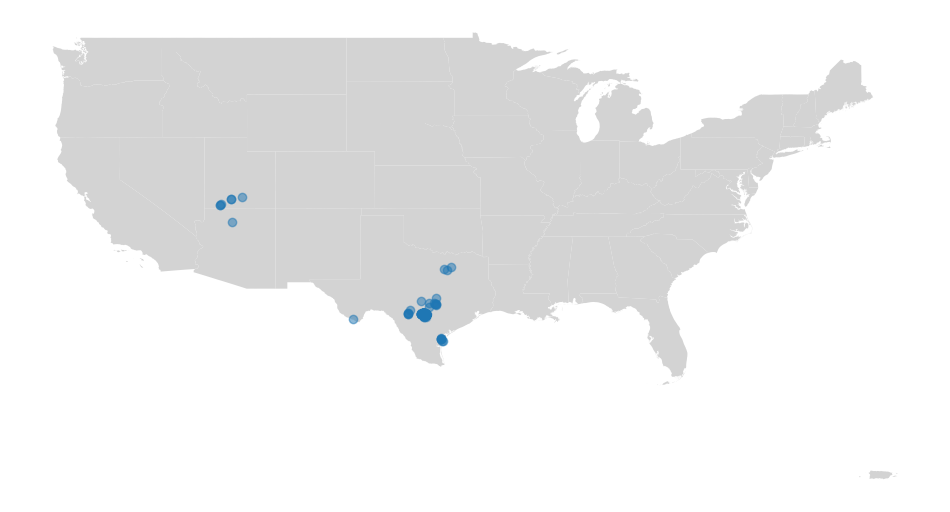

In [39]:
g, ax = plt.subplots(figsize=(12, 12))
states.plot(ax=ax, color='lightgrey')

# activity clusters
sample_gdf.plot(ax=ax, alpha=0.5)
ax.axis('off')

(-127.74018625000001, -62.24358475, 16.3082261, 50.9594119)

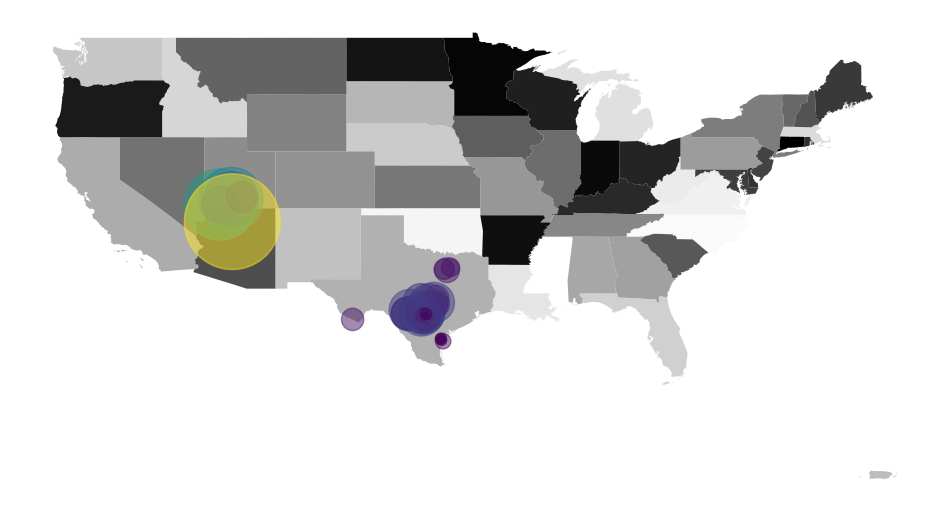

In [40]:
g, ax = plt.subplots(figsize=(12, 12))
states.plot(ax=ax, cmap='binary')

# elevation heatmap
sample_gdf.plot(ax=ax, column='elevation_gain_ft', markersize=sample_gdf.elevation_gain_ft, alpha=0.5)
ax.axis('off')

(-127.74018625000001, -62.24358475, 16.3082261, 50.9594119)

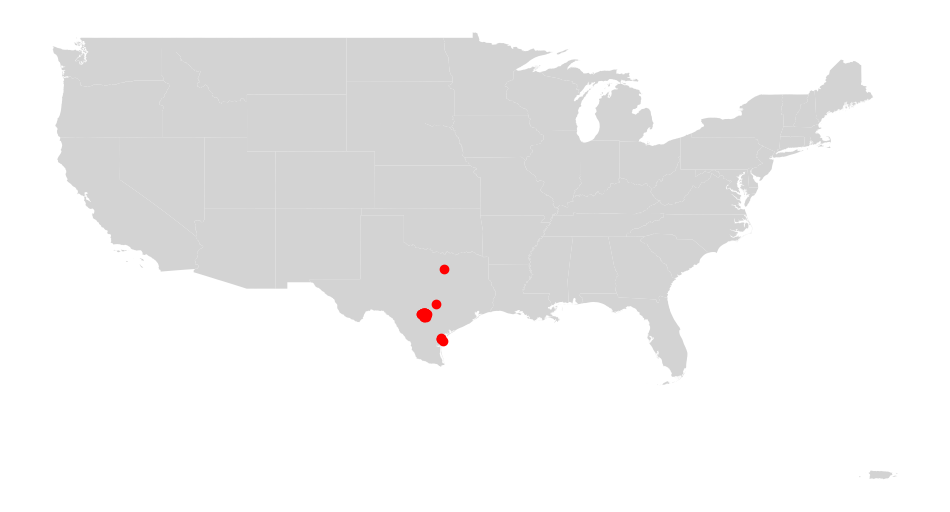

In [41]:
# run map
g, ax = plt.subplots(figsize=(12, 12))
states.plot(ax=ax, color='lightgrey')

sample_gdf_run = sample_gdf[sample_gdf['Activity Type'] == 'Run']

sample_gdf_run.plot(ax=ax, color='red')
ax.axis('off')

(-127.74018625000001, -62.24358475, 16.3082261, 50.9594119)

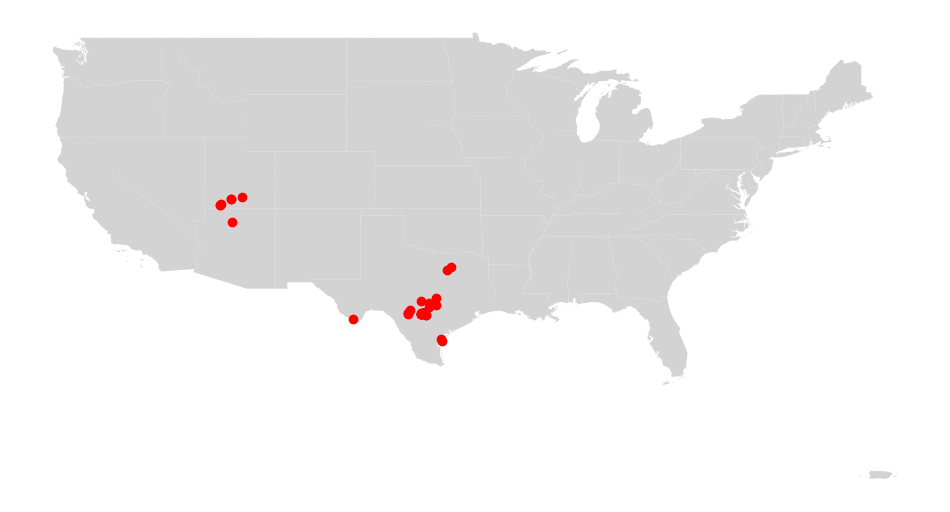

In [42]:
# hike map
g, ax = plt.subplots(figsize=(12, 12))
states.plot(ax=ax, color='lightgrey')

sample_gdf_hike = sample_gdf[sample_gdf['Activity Type'] == 'Hike']

sample_gdf_hike.plot(ax=ax, color='red')
ax.axis('off')

In [43]:
# All activities with distance
map = folium.Map(location=[36, -100],
               zoom_start=4)
#                zoom_control=False,
#                scrollWheelZoom=False,
#                dragging=False)

frequency_data = [[point.xy[1][0], point.xy[0][0]] for point in sample_gdf.geometry]

plugins.MarkerCluster(frequency_data).add_to(map)

map